In [1]:
import torch
import torch.nn as nn

import numpy as np , pandas as pd
import matplotlib.pyplot as plt
import configparser

import pickle


In [2]:
config = configparser.ConfigParser()
config.read('settings.ini')

config= {key: int(value) for key, value in config['INCOME_DATASET'].items()}
config

{'vocab_length': 21979,
 'val_split': 20,
 'test_split': 10,
 'epochs': 2,
 'n_embed': 992,
 'n_heads': 31,
 'context_window': 38,
 'transformer_blocks': 2,
 'batch_size': 32,
 'random_seed': 123}

In [3]:
from local_utils import tokenize_dataset , read_dataset , decoder

In [4]:
df = pd.read_csv("../../datasets/adult.csv")

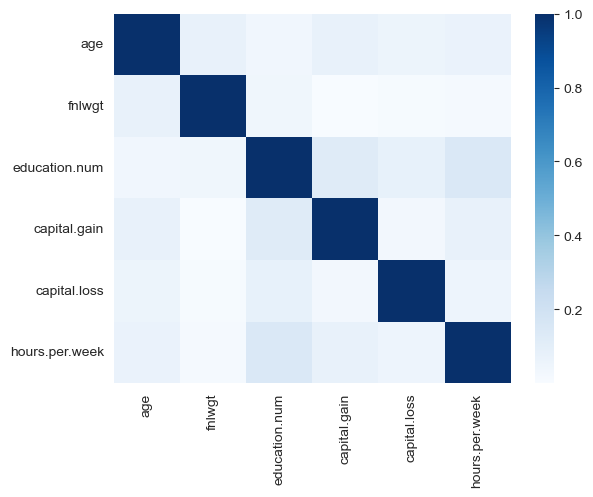

In [5]:
# reorder columns
import seaborn as sns
float_cols =  df.select_dtypes(exclude=object).columns
corr_matrix = df[float_cols].corr().abs()
sns.heatmap(corr_matrix,cmap="Blues")
plt.show()

In [6]:
reorder_cols = corr_matrix.mean().sort_values()
reorder_cols

fnlwgt            0.191549
capital.loss      0.205637
capital.gain      0.218460
age               0.219563
hours.per.week    0.228052
education.num     0.238400
dtype: float64

In [7]:
cat_cols = df.select_dtypes(include=object).columns.tolist()
cat_cols

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country',
 'income']

In [8]:
df = df[cat_cols + reorder_cols.index.tolist()]

# encoding

In [9]:
try:
    df = read_dataset(df)
except pd.errors.SettingWithCopyWarning:
    pass
df

,blank,start,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income,fnlwgt,capital_loss,capital_gain,age,hours_per_week,education_num,end
0,<blank>,<start>,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K,77053,4356,0,90,40,9,<end>
1,<blank>,<start>,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K,132870,4356,0,82,18,9,<end>
2,<blank>,<start>,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States,<=50K,186061,4356,0,66,40,10,<end>
3,<blank>,<start>,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K,140359,3900,0,54,40,4,<end>
4,<blank>,<start>,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K,264663,3900,0,41,40,10,<end>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,<blank>,<start>,Private,Some-college,Never-married,Protective-serv,Not-in-family,White,Male,United-States,<=50K,310152,0,0,22,40,10,<end>
32557,<blank>,<start>,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K,257302,0,0,27,38,12,<end>
32558,<blank>,<start>,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K,154374,0,0,40,40,9,<end>
32559,<blank>,<start>,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K,151910,0,0,58,40,9,<end>


In [10]:
tokenizer , col_code , encoded_docs = tokenize_dataset(df,float_transform="yeo-johnson")


    Available Float Quantization method (multi-token) : yeo-johnson , quantile , log , robust
    _______________________________ 
    / Tokenizing your dataset       \
    \     > This might take a while /
    ------------------------------- 
           \   ^__^
            \  (oo)\_______
               (__)\       )\/\
                   ||----w |
                   ||     ||
    


In [11]:
# heres how to decode ...
print(f"encoded docs example : {encoded_docs[0]}")
decoded_eg = decoder(encoded_docs[0],df,col_code)
print(f"Decoded : {decoded_eg}")

encoded docs example : [0, 1, 2, 11, 27, 34, 49, 55, 60, 62, 104, 106, 21755, 21760, 21771, 21778, 21786, 21788, 21801, 21808, 21819, 21822, 21837, 21841, 21851, 21860, 21862, 21872, 21885, 21897, 21902, 21904, 21918, 21930, 21938, 21944]
Decoded : ['<blank>', '<start>', '?', 'HS-grad', 'Widowed', '?', 'Not-in-family', 'White', 'Female', 'United-States', '<=50K', '77053', '22.213064221683393', '0.00028949718149151593', '89.98933063603158', '40.00703882959338', '9.000964096125402', '<end>']


In [13]:
# sample decoding and encoding
# object
wrk_class = "State-gov"
encoded_wrk_class = col_code.encode("workclass",wrk_class)
decoded_wrk_class = col_code.decode("workclass",encoded_wrk_class)
print(encoded_wrk_class,decoded_wrk_class)

[4] State-gov


/Users/adi/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


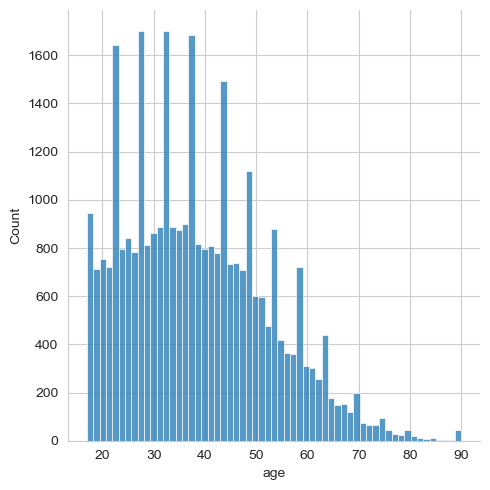

In [15]:
# you can check out the precision error here for the float tokenizer
sns.displot(df["age"])
plt.show()

In [23]:
# precision error if likely in the distribution
age = 20
encoded_age = col_code.encode("age",age)
decoded_age = col_code.decode("age",encoded_age)
print(encoded_age,decoded_age)

# if not in the distribution
age = 13
encoded_age = col_code.encode("age",age)
decoded_age = col_code.decode("age",encoded_age)
print(encoded_age,decoded_age)


[21818, 21821, 21835, 21849, 21858] 20.001860322372632
[21818, 21822, 21836, 21842, 21857] 13.00121164439984


In [27]:
# token sizes
for col_name , size in zip( col_code.columns , col_code.sizes):
    print(f"{col_name:15} -> {size} tokens")

blank           -> 1 tokens
start           -> 1 tokens
workclass       -> 1 tokens
education       -> 1 tokens
marital_status  -> 1 tokens
occupation      -> 1 tokens
relationship    -> 1 tokens
race            -> 1 tokens
sex             -> 1 tokens
native_country  -> 1 tokens
income          -> 1 tokens
fnlwgt          -> 1 tokens
capital_loss    -> 4 tokens
capital_gain    -> 4 tokens
age             -> 5 tokens
hours_per_week  -> 5 tokens
education_num   -> 5 tokens
end             -> 1 tokens


In [12]:
encoded_docs = torch.tensor(encoded_docs)
encoded_docs.shape

torch.Size([32561, 36])

In [28]:
encoded_docs

tensor([[    0,     1,     2,  ..., 21930, 21938, 21944],
        [    0,     1,     3,  ..., 21930, 21938, 21944],
        [    0,     1,     2,  ..., 21931, 21939, 21944],
        ...,
        [    0,     1,     3,  ..., 21930, 21938, 21944],
        [    0,     1,     3,  ..., 21930, 21938, 21944],
        [    0,     1,     3,  ..., 21930, 21938, 21944]])

In [29]:
torch.save(encoded_docs,"encoded_vars/encoded_docs_income.pt")

In [30]:
token_vars = {'col_code': col_code, 'df': df, 'tokenizer': tokenizer}

with open('encoded_vars/token_vars_income.pkl', 'wb') as file:
    pickle.dump(token_vars, file)